In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input

from sklearn.metrics import recall_score, f1_score, matthews_corrcoef
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

import os
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import time


2025-06-23 20:32:20.703248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-23 20:32:20.703312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-23 20:32:20.704720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-23 20:32:20.711866: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-23 20:32:21.484775: W tensorflow/compiler/tf2

In [2]:
import tensorflow as tf

# Verificar si detecta GPUs
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-06-23 20:32:22.896659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-23 20:32:22.921914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-23 20:32:22.922083: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
base_dir = './Banana Ripeness Classification Dataset V2'
print(os.listdir(base_dir))

['train', 'valid', 'test']


In [4]:
lr ="001"
Et = "10"
l_rate = 0.001
Epoch_test = 10

In [5]:
def save_test_accuracy(experiment_name, test_accuracy, filename='test_accuracy_log.csv'):
    new_entry = pd.DataFrame([{
        'experiment': experiment_name,
        'test_accuracy': test_accuracy
    }])

    if os.path.exists(filename):
        df_existing = pd.read_csv(filename)
        # Eliminar cualquier fila con el mismo experimento
        df_existing = df_existing[df_existing['experiment'] != experiment_name]
        # Agregar nueva entrada
        df_combined = pd.concat([df_existing, new_entry], ignore_index=True)
    else:
        df_combined = new_entry

    df_combined.to_csv(filename, index=False)
    print(f"Test accuracy for '{experiment_name}' saved to '{filename}'.")

In [6]:
class MetricsLogger(Callback):
    def __init__(self, validation_generator, experiment_name=None):
        super(MetricsLogger, self).__init__()
        self.validation_generator = validation_generator
        self.history = []
        self.experiment_name = experiment_name
        self.epoch_start_time = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        logs = logs or {}

        self.validation_generator.reset()
        
        y_true = []
        y_pred = []
        
        for i in range(len(self.validation_generator)):
            batch_x, batch_y = self.validation_generator[i]
            
            # Predicciones para este batch
            batch_predictions = self.model.predict(batch_x, verbose=0)
            batch_pred_classes = np.argmax(batch_predictions, axis=1)
            
            # Clases verdaderas para este batch
            batch_true_classes = np.argmax(batch_y, axis=1)
            
            # Agregar a las listas
            y_pred.extend(batch_pred_classes)
            y_true.extend(batch_true_classes)
        
        # Convertir a arrays numpy
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Calcular métricas (ahora están correctamente alineadas)
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')
        mcc = matthews_corrcoef(y_true, y_pred)

        self.history.append({
            'experiment': self.experiment_name if self.experiment_name else 'default',
            'epoch': epoch + 1,
            'accuracy': logs.get('accuracy'),
            'loss': logs.get('loss'),
            'val_accuracy': logs.get('val_accuracy'),
            'val_loss': logs.get('val_loss'),
            'recall': recall,
            'f1_score': f1,
            'mcc': mcc,
            'epoch_time': round(epoch_duration, 2)
        })
        
        # Resetear para el siguiente uso
        self.validation_generator.reset()
        
        # Mostrar progreso
        print(f"Epoch {epoch+1}: val_acc={logs.get('val_accuracy'):.4f}, "
              f"recall={recall:.4f}, f1={f1:.4f}, mcc={mcc:.4f}")

    def save_to_csv(self, filename='metrics_log.csv'):
        new_df = pd.DataFrame(self.history)

        if os.path.exists(filename):
            existing_df = pd.read_csv(filename)
            # Eliminar filas con experimentos ya existentes
            existing_df = existing_df[~existing_df['experiment'].isin(new_df['experiment'])]
            # Combinar con los nuevos datos
            combined_df = pd.concat([existing_df, new_df], ignore_index=True)
        else:
            combined_df = new_df

        combined_df.to_csv(filename, index=False)
        print(f"Metrics saved to '{filename}' with {len(new_df)} new rows.")

In [7]:
image_size = (299, 299)  # Tamaño compatible con xception
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = valid_test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Importante para la matriz de confusión
)


Found 9440 images belonging to 4 classes.
Found 2023 images belonging to 4 classes.
Found 2015 images belonging to 4 classes.


In [8]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False

# Igual que antes
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 clases como antes

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=l_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

2025-06-23 20:32:23.355675: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-23 20:32:23.355887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-23 20:32:23.355977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

In [9]:
metrics_logger = MetricsLogger(
    validation_generator=valid_generator, 
    experiment_name=f'xception_{l_rate}_{Epoch_test}'
)

In [10]:
with tf.device('/GPU:0'):
  history = model.fit(
      train_generator,
      epochs=Epoch_test,
      validation_data=valid_generator,
      callbacks=[metrics_logger]
  )

metrics_logger.save_to_csv('resultados_modelos.csv')

Epoch 1/10


2025-06-23 20:32:28.050710: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-23 20:32:29.946711: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcc254465c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-23 20:32:29.946717: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2025-06-23 20:32:29.952438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750710750.044627   42201 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 [==============================] - 162s 536ms/step - loss: 0.3575 - accuracy: 0.8725 - val_loss: 0.1656 - val_accuracy: 0.9441
Epoch 2/10
295/295 [==============================] - 156s 530ms/step - loss: 0.2216 - accuracy: 0.9214 - val_loss: 0.1339 - val_accuracy: 0.9535
Epoch 3/10
295/295 [==============================] - 157s 532ms/step - loss: 0.1889 - accuracy: 0.9323 - val_loss: 0.1008 - val_accuracy: 0.9679
Epoch 4/10
295/295 [==============================] - 157s 532ms/step - loss: 0.1730 - accuracy: 0.9392 - val_loss: 0.1031 - val_accuracy: 0.9649
Epoch 5/10
295/295 [==============================] - 156s 530ms/step - loss: 0.1649 - accuracy: 0.9410 - val_loss: 0.1180 - val_accuracy: 0.9585
Epoch 6/10
295/295 [==============================] - 160s 543ms/step - loss: 0.1542 - accuracy: 0.9431 - val_loss: 0.0965 - val_accuracy: 0.9689
Epoch 7/10
295/295 [==============================] - 158s 535ms/step - loss: 0.1386 - accuracy: 0.9497 - val_loss: 0.0892 - val_accura

63/63 [==============================] - 8s 120ms/step
Classification Report
              precision    recall  f1-score   support

    overripe       0.99      0.97      0.98       479
        ripe       0.97      0.96      0.97       520
      rotten       0.97      0.98      0.97       541
      unripe       0.98      1.00      0.99       475

    accuracy                           0.98      2015
   macro avg       0.98      0.98      0.98      2015
weighted avg       0.98      0.98      0.98      2015

Confusion Matrix


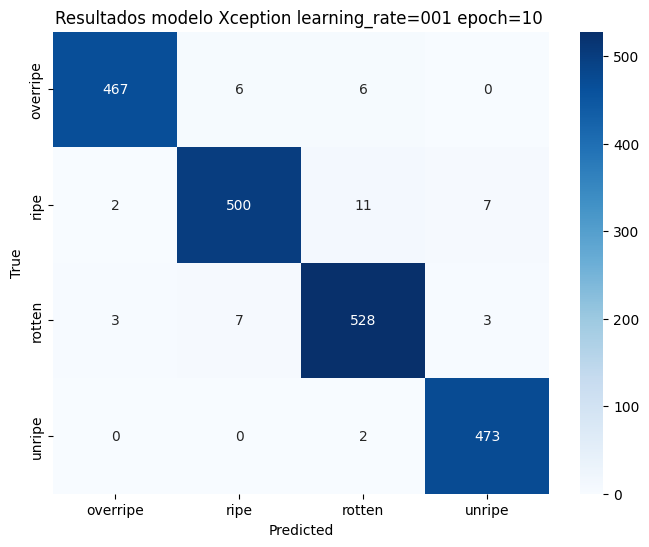

In [11]:
# Predicciones
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Reporte y matriz de confusión
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()))

print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)

# Visualizar la matriz
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), cmap='Blues')
plt.title(f"Resultados modelo Xception learning_rate={lr} epoch={Et} ")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(f'Matrices de confusion/XCEPTION/matriz_confusion_lr{lr}_epoch{Et}.png', bbox_inches='tight')
plt.show()


In [12]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(test_generator.classes, y_pred)
experiment_name = f'xception_{l_rate}_{Epoch_test}'

save_test_accuracy(experiment_name, test_accuracy)

Test accuracy for 'xception_0.001_10' saved to 'test_accuracy_log.csv'.


In [13]:
model.save(f'modelos/XCEPTION_{lr}_{Et}.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
